In [3]:
#|default_exp graphs
import numpy as np

# Graph Creation Utils

Written by Alex Tong & Guillaume Huguet for [KrishnaswamyLab/HeatGeo: Embedding with the Heat-geodesic dissimilarity](https://github.com/KrishnaswamyLab/HeatGeo). Adapted for diffusion curvature.

This uses the marvelous library PyGSP to handle graph creation and basic graph signal processing.

By default we use the alpha-decay kernel from [PHATE](https://www.nature.com/articles/s41587-019-0336-3). We implemented other types of kernels, to use them you need to install our package with `[dev]`.

In [4]:
#| export
import graphtools as gt
import pygsp
from typing import Union
from graphtools.matrix import set_diagonal, to_array
from scipy import sparse
from sklearn.preprocessing import normalize
import numpy as np

try:
    # optional dependencies
    import scanpy as sc
    import umap
except ImportError as imp_err:
    sc = imp_err
    umap = imp_err

In [5]:
#| export

def diff_op(graph):
    """
    Compute the diffusion operator for a pygsp graph.
    """
    # assert isinstance(graph, pygsp.graphs.Graph)
    # K = set_diagonal(graph.W, 1)
    diff_op_ = normalize(graph.W, norm="l1", axis=1)
    return diff_op_


def kernel_degree(graph):
    """
    Compute the kernel degree for a pygsp graph.
    """
    assert isinstance(graph, pygsp.graphs.Graph)
    K = set_diagonal(graph.W, 1)
    return to_array(K.sum(axis=1)).reshape(-1, 1)


def diff_aff(graph):
    """
    Compute the diffusion affinity for a pygsp graph.
    """
    assert isinstance(graph, pygsp.graphs.Graph)
    K = set_diagonal(graph.W, 1)
    row_degrees = kernel_degree(graph)

    if sparse.issparse(K):
        # diagonal matrix
        degrees = sparse.csr_matrix(
            (
                1 / np.sqrt(row_degrees.flatten()),
                np.arange(len(row_degrees)),
                np.arange(len(row_degrees) + 1),
            )
        )
        return degrees @ K @ degrees
    else:
        col_degrees = row_degrees.T
        return (K / np.sqrt(row_degrees)) / np.sqrt(col_degrees)


###------------------------Graphs Classes ----------------------------###


def get_knn_graph(X, knn=5, **kwargs):
    return pygsp.graphs.NNGraph(X, k=knn)


def get_alpha_decay_graph(
    X,
    knn: int = 5,
    decay: float = 40.0,
    anisotropy: float = 0,
    n_pca: int = None,
    **kwargs
):
    return gt.Graph(
        X,
        knn=knn,
        decay=decay,
        anisotropy=anisotropy,
        n_pca=n_pca,
        use_pygsp=True,
        random_state=42,
    ).to_pygsp()


def get_scanpy_graph(X, knn=5, **kwargs):

    if isinstance(sc, ImportError):
        raise ImportError("Scanpy is not installed.")

    adata = sc.AnnData(X)
    sc.pp.neighbors(adata, n_neighbors=knn)
    w = adata.obsp["connectivities"]
    return pygsp.graphs.Graph(w)


def get_umap_graph(X, knn=5, **kwargs):  # knn default to 15 in UMAP
    if isinstance(umap, ImportError):
        raise ImportError("UMAP is not installed.")
    umap_op = umap.UMAP(n_neighbors=knn, metric="euclidean")
    umap_op.fit(X)
    w = umap_op.graph_.toarray()
    return pygsp.graphs.Graph(w)

# The Differentiable Kernel

In [6]:
#|export
import jax
import jax.numpy as jnp

def generic_kernel(
        D, # distance matrix
        sigma, # kernel bandwidth
        anisotropic_density_normalization, 

):  
    W = (1/(sigma*np.sqrt(2*jnp.pi)))*jnp.exp((-D**2)/(2*sigma**2))
    D = jnp.diag(1/((jnp.sum(W,axis=1)+1e-8)**anisotropic_density_normalization))
    W = D @ W @ D
    return W

In [7]:
#|export

def diffusion_matrix_from_affinities(
        W
):
    W = W + jnp.eye(len(W))*1e-8
    D = jnp.diag(1/jnp.sum(W,axis=1))
    P = D @ W
    return P

In [8]:
from diffusion_curvature.utils import random_jnparray
from diffusion_curvature.distances import pairwise_euclidean
X = random_jnparray(100,9)
D = pairwise_euclidean(X,X)
W = generic_kernel(D,0.7,0.5)
P = diffusion_matrix_from_affinities(W)

In [9]:
import jax.numpy as jnp
jnp.max(jnp.array([1, 0.4, 1, 3])/jnp.array([1e-8,1,1,1]))

Array(1.e+08, dtype=float32)

In [10]:
jnp.array([1, 0.4, 1, 3])/jnp.array([0,1,1,1])

Array([inf, 0.4, 1. , 3. ], dtype=float32)

# Graph Testing

In [15]:
from diffusion_curvature.datasets import *
from diffusion_curvature.utils import *
from diffusion_curvature.heat_diffusion import *
X_torus,ks = torus(5000,use_guide_points=True)

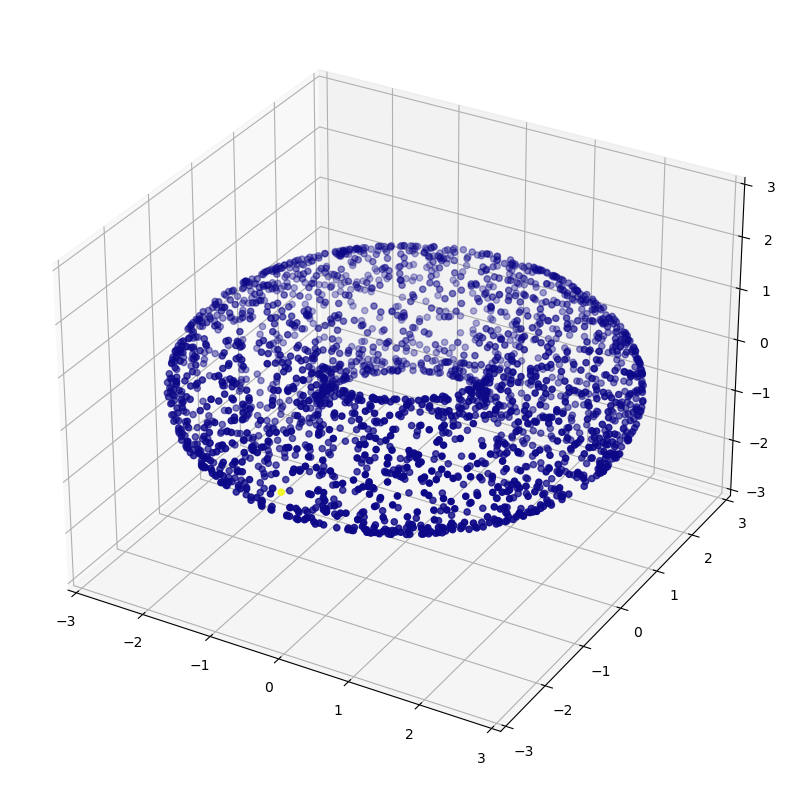

In [22]:
G_torus = get_alpha_decay_graph(X_torus, decay=None, knn=30, anisotropy=1, )
P = diff_op(G_torus).todense() # is sparse, by default
P = jnp.array(P)
Pt = jax_power_matrix(P,30)
plot_3d(X_torus, P[0])

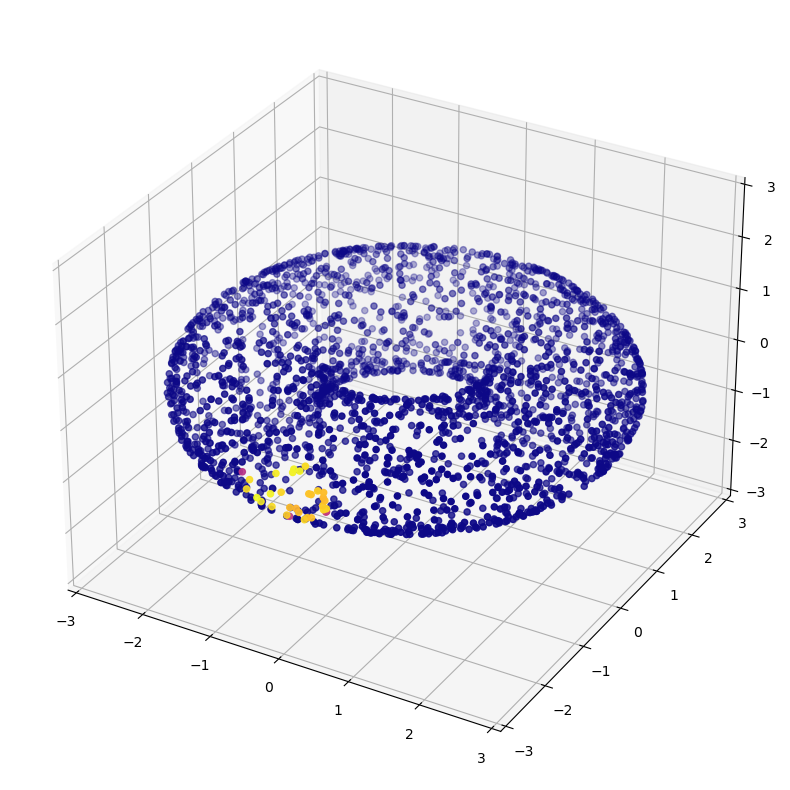

In [21]:
plot_3d(X_torus, G_torus.P[0].toarray())

In [23]:
np.allclose(diff_op(G_torus).toarray(), G_torus.P.toarray())

False

In [26]:

A = G_torus.K.toarray()
P_homemade = diffusion_matrix_from_affinities(A)

In [31]:
np.allclose(P_homemade, G_torus.P.toarray(), atol=1e-4)

True

In [28]:
P_homemade

Array([[0.0334698 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03510092, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03167431, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.03027344, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03521152,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03522947]], dtype=float32)

In [29]:
G_torus.P.toarray()

array([[0.03346897, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03508904, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03166429, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.03027342, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03520697,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03523469]])

In [33]:
P

Array([[0.96891046, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.9683374 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.9701013 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.9696673 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.9694721 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.96949625]], dtype=float32)

In [37]:
G_torus.K.toarray()

array([[0.00111111, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00118906, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00100781, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00097656, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0011491 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0011491 ]])

In [1]:
!nbdev_export

/usr/bin/bash: line 1: nbdev_export: command not found
